In [16]:
import pandas as pd
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split
from xgboost import XGBClassifier
import numpy as np
from sklearn.model_selection import cross_val_score
from sklearn.metrics import classification_report
import matplotlib.pyplot as plt

In [17]:
df = pd.read_excel("二分类.xlsx", sheet_name="2")
df['医疗服务机构'] = df['医疗服务机构'].fillna(df['医疗服务机构'].median())

In [18]:
X = df.drop(columns=['bq1'])
y = df.bq1

In [19]:
smote = SMOTE(random_state=42)  
X_resampled, y_resampled = smote.fit_resample(X, y)

c:\Users\24849\Desktop\多分类转二分类\venv\Lib\site-packages\joblib\externals\loky\backend\context.py:136: UserWarning: Could not find the number of physical cores for the following reason:
found 0 physical cores < 1
Returning the number of logical cores instead. You can silence this warning by setting LOKY_MAX_CPU_COUNT to the number of cores you want to use.
  warnings.warn(
  File "c:\Users\24849\Desktop\多分类转二分类\venv\Lib\site-packages\joblib\externals\loky\backend\context.py", line 282, in _count_physical_cores
    raise ValueError(f"found {cpu_count_physical} physical cores < 1")


In [21]:
y_resampled.value_counts()

bq1
2     196
8     196
4     196
11    196
5     196
18    196
9     196
6     196
7     196
10    196
20    196
12    196
1     196
15    196
14    196
13    196
3     196
17    196
16    196
19    196
0     196
Name: count, dtype: int64

In [22]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [27]:
def evaluate_xgb(params, X_train, y_train):
    n_estimators_min, n_estimators_max = 100, 1000
    learning_rate_min, learning_rate_max = 0.01, 0.3
    n_estimators = int(params[0] * (n_estimators_max - n_estimators_min)) + n_estimators_min
    learning_rate = params[1] * (learning_rate_max - learning_rate_min) + learning_rate_min

    model = XGBClassifier(n_estimators=n_estimators, learning_rate=learning_rate, 
                          objective='multi:softmax', eval_metric='mlogloss')
    
    cv_scores = cross_val_score(model, X_train, y_train, cv=3, scoring='accuracy')
    mean_accuracy = cv_scores.mean()

    return mean_accuracy


def sparrow_search_algorithm(X_train, y_train, population_size, max_iterations):
    param_dim = 2
    sparrow_positions = np.random.uniform(low=0, high=1, size=(population_size, param_dim))
    num_producers = int(0.2 * population_size)
    ST = 0.8  
    DT = 0.5  

    fitness = np.array([evaluate_xgb(individual, X_train, y_train) for individual in sparrow_positions])
    sorted_indices = np.argsort(fitness)[::-1]
    sorted_positions = sparrow_positions[sorted_indices]
    for iteration in range(max_iterations):
        # update producers
        for i in range(num_producers):
            r1 = np.random.rand()
            r2 = np.random.rand()
            if r1 < ST:
                sorted_positions[i] += r2 * (sorted_positions[0] - sorted_positions[i])
            else:
                sorted_positions[i] += np.random.uniform(-1, 1) * np.ones_like(sorted_positions[i])
        # updated scroungers
        for i in range(num_producers, population_size):
            r1 = np.random.rand()
            r2 = np.random.rand()
            if r1 < DT:
                sorted_positions[i] += r2 * (sorted_positions[(np.random.randint(0, num_producers))] - sorted_positions[i])
            else:
                sorted_positions[i] += r2 * (sorted_positions[i] - sorted_positions[-1])

        # Ensure population remains within bounds
        sorted_positions = np.clip(sorted_positions, [0, 0], [1, 1])

        fitness = np.array([evaluate_xgb(individual, X_train, y_train) for individual in sparrow_positions])
        sorted_indices = np.argsort(fitness)[::-1]
        sorted_positions = sparrow_positions[sorted_indices]

    best_params = sorted_positions[0]
    best_fitness = np.max(fitness)
    return best_params, best_fitness

In [28]:
best_params, best_fitness = sparrow_search_algorithm(X_train, y_train, population_size=20, max_iterations=1)

In [29]:
n_estimators = int(best_params[0] * 900) + 100  
learning_rate = best_params[1] * 0.29 + 0.01  
n_estimators, learning_rate  

(591, np.float64(0.23264224186689317))

In [30]:
xgb_model = XGBClassifier(objective='multi:softmax', num_class=21, eval_metric='mlogloss',
                          n_estimators=n_estimators, learning_rate=learning_rate)

In [31]:
xgb_model.fit(X_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='mlogloss',
              feature_types=None, gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=np.float64(0.23264224186689317), max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=591, n_jobs=None, num_class=21,
              num_parallel_tree=None, ...)

In [32]:
y_pred = xgb_model.predict(X_test)

In [33]:
xgb_cv_scores = cross_val_score(xgb_model, X_train, y_train, cv=3, scoring='accuracy')
xgb_mean_accuracy = xgb_cv_scores.mean()
print(xgb_mean_accuracy)

0.05301556672528179


In [34]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.00      0.00      0.00         2
           1       0.00      0.00      0.00        11
           2       0.02      0.03      0.02        30
           3       0.00      0.00      0.00        12
           4       0.05      0.03      0.04        30
           5       0.00      0.00      0.00        14
           6       0.05      0.08      0.06        13
           7       0.17      0.19      0.18        16
           8       0.00      0.00      0.00         3
           9       0.02      0.03      0.03        34
          10       0.12      0.03      0.05        33
          11       0.00      0.00      0.00        14
          12       0.00      0.00      0.00         9
          13       0.00      0.00      0.00         6
          14       0.00      0.00      0.00         6
          15       0.00      0.00      0.00        20
          17       0.00      0.00      0.00         4
          18       0.00    

c:\Users\24849\Desktop\多分类转二分类\venv\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\24849\Desktop\多分类转二分类\venv\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\24849\Desktop\多分类转二分类\venv\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [35]:
# 设置支持中文的字体
plt.rcParams['font.sans-serif'] = ['SimHei']  # 使用黑体字体
plt.rcParams['axes.unicode_minus'] = False  # 正常显示负号

<Figure size 1000x800 with 0 Axes>

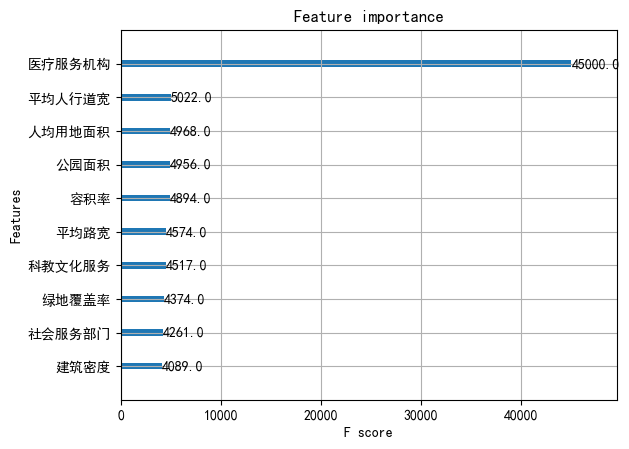

In [36]:
from xgboost import plot_importance

plt.figure(figsize=(10, 8))
plot_importance(xgb_model, max_num_features=10)  # 显示最重要的10个特征
plt.show()